Importación y carga de datos de CoverType

In [1]:
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Cargar dataset CoverType
data = sklearn.datasets.fetch_covtype(as_frame=True)

X = data.data      
y = data.target    

print(X.head())
print(y.head())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          221.0           232.0          148.0   
1          220.0           235.0          151.0   
2          234.0           238.0   

In [2]:
binary_cols = [col for col in X.columns if set(X[col].unique()) <= {0,1}]
numeric_cols = [col for col in X.columns if col not in binary_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print("\nScaled values:\n", X_scaled[numeric_cols].head())
print("\nBinary columns left untouched:\n", X_scaled[binary_cols].head())


Scaled values:
    Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0  -1.297805 -0.935157 -1.482820                         -0.053767   
1  -1.319235 -0.890480 -1.616363                         -0.270188   
2  -0.554907 -0.148836 -0.681563                         -0.006719   
3  -0.622768 -0.005869  0.520322                         -0.129044   
4  -1.301377 -0.988770 -1.616363                         -0.547771   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       -0.796273                        -1.180146   
1                       -0.899197                        -1.257106   
2                        0.318742                         0.532212   
3                        1.227908                         0.474492   
4                       -0.813427                        -1.256464   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.330743        0.439143       0.142960   
1       0.293388        0.590899       

De acuerdo con las variables vistas en este conjunto de datos se observa lo siguiente: 
En este corte, las muestras están a baja altitud y con pendientes suaves; en promedio aparecen algo más cerca del agua y de carreteras que el conjunto general. La iluminación sugiere mayor exposición por la mañana/mediodía y menor por la tarde (3 pm), y todas están muy lejos de puntos de incendios (z ≈ 3). En binarios, todas pertenecen a la misma wilderness area y los Soil_Type salen en 0, lo cual es inusual para un one-hot y amerita revisar la codificación de suelos.

In [3]:
y_binary = (y == 2).astype(int)  # 1 = normal (tipo 2), 0 = anómalo

# Revisar
print(y.value_counts())       # distribución original
print(y_binary.value_counts()) # distribución binaria

Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64
Cover_Type
0    297711
1    283301
Name: count, dtype: int64


De acuerdo con las variables vistas en este conjunto de datos se observa lo siguiente: 

Como se puede observar, este es el tipo de Los Cover_Type están fuertemente desbalanceados: el tipo 2 concentra ~48.8% (283,301) y el tipo 1 ~36.4% (211,840); el resto es cola larga (3: ~6.2%, 7: ~3.5%, 6: ~3.0%, 5: ~1.6%, 4: ~0.5%; total 581,012). En la versión binaria (0/1) el set queda casi balanceado (0: 51.3%, 1: 48.7%), probablemente indicando que “1” agrupa al tipo 2 original. Implicación: para el modelo multiclase usa class weights, stratified split y métricas macro (macro-F1, balanced accuracy) para no inflar desempeño por la clase mayoritaria; en el binario, el balance permite métricas estándar pero conviene reportar también AUC y F1.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Split normal and anomaly subsets
X_normal = X[y_binary == 1]
X_anomaly = X[y_binary == 0]

# ---- TRAIN & VALIDATION ----
# Only normals
X_train, X_val = train_test_split(
    X_normal, test_size=0.2, random_state=42
)

# ---- TEST ----
# Contains both normals and anomalies
X_test = pd.concat([X_normal.sample(5000, random_state=42),
                    X_anomaly.sample(5000, random_state=42)])
y_test = np.concatenate([np.ones(5000), np.zeros(5000)])  # 1=normal, 0=anomaly

# Shuffle test set (mix normal + anomaly)
test_df = X_test.copy()
test_df["label"] = y_test
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Final test sets
X_test = test_df.drop(columns=["label"])
y_test = test_df["label"].values
y_test = y_test.astype(int)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape, "with labels:", np.bincount(y_test))

KeyboardInterrupt: 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

input_dim = X_train.shape[1]

autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

# Error de reconstrucción en el conjunto de validación
val_recon = autoencoder.predict(X_val)
val_mse = np.mean(np.square(X_val - val_recon), axis=1)

# Umbral: percentil 95 del error en validación
threshold = np.percentile(val_mse, 95)
print("Umbral de reconstrucción:", threshold)

# Evaluar sobre test
test_recon = autoencoder.predict(X_test)
test_mse = np.mean(np.square(X_test - test_recon), axis=1)
y_pred_ae = (test_mse > threshold).astype(int)  # 1=anómalo

Epoch 1/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 446409.1562 - val_loss: 444474.5625
Epoch 2/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 446383.7812 - val_loss: 444474.5625
Epoch 3/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 446384.1875 - val_loss: 444474.4688
Epoch 4/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 446384.0000 - val_loss: 444474.4688
Epoch 5/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 446383.8750 - val_loss: 444474.4688
Epoch 6/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 446384.0938 - val_loss: 444474.4688
Epoch 7/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 446383.6562 - val_loss: 444474.4688
Epoch 8/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 446383.9062 - val_loss: 444474.4688
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step
Umbral de reconstrucción: 1092746.9820002187
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step


In [6]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.5, random_state=42)
iso.fit(X_train)

y_pred_if = iso.predict(X_test)
y_pred_if = np.where(y_pred_if == -1, 1, 0)  # -1 = anomalía

from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(X_train)

y_pred_lof = lof.predict(X_test)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

c:\Users\danie\Documentos\Data_Science\Labs\Lab8\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



--- Autoencoder ---
ROC-AUC: 0.53087196
PR-AUC: 0.5494285508861954
F1: 0.0905318747642399
Precision: 0.7947019867549668
Recall: 0.048
[[4938   62]
 [4760  240]]


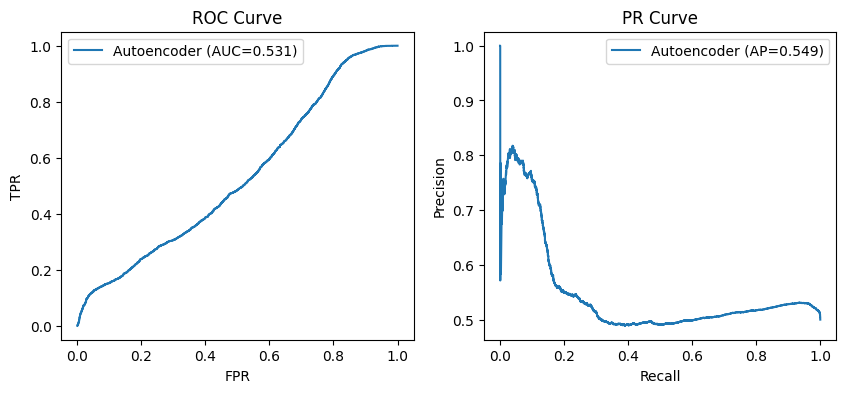


--- Isolation Forest ---
ROC-AUC: 0.39273270000000005
PR-AUC: 0.4149834872191164
F1: 0.466767087177556
Precision: 0.4409462824617574
Recall: 0.4958
[[1857 3143]
 [2521 2479]]


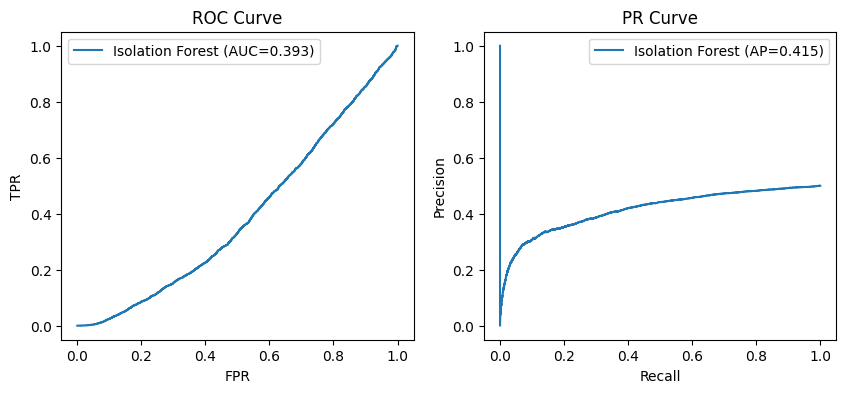

c:\Users\danie\Documentos\Data_Science\Labs\Lab8\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



--- LOF ---
ROC-AUC: 0.0455796
PR-AUC: 0.31216553466767516
F1: 0.0023631350925561244
Precision: 0.003439052350019106
Recall: 0.0018
[[2392 2608]
 [4991    9]]


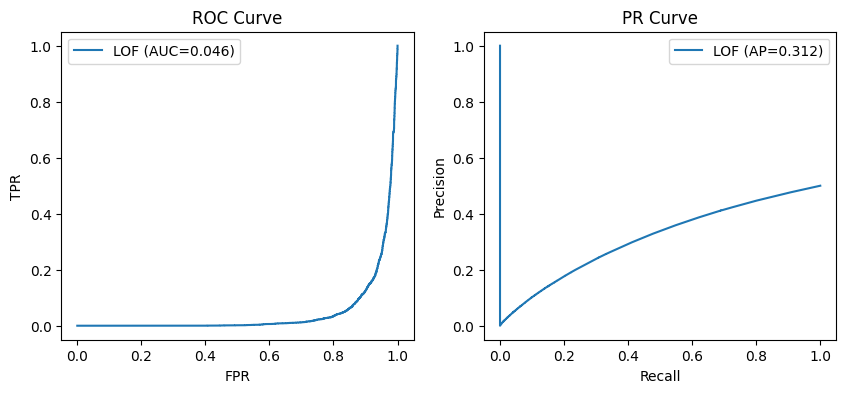

In [9]:
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, average_precision_score,
    f1_score, precision_score, recall_score, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

def evaluar_modelo(y_true, y_pred, scores, nombre):
    print(f"\n--- {nombre} ---")
    print("ROC-AUC:", roc_auc_score(y_true, scores))
    print("PR-AUC:", average_precision_score(y_true, scores))
    print("F1:", f1_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

    fpr, tpr, _ = roc_curve(y_true, scores)
    prec, rec, _ = precision_recall_curve(y_true, scores)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'{nombre} (AUC={roc_auc_score(y_true, scores):.3f})')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(rec, prec, label=f'{nombre} (AP={average_precision_score(y_true, scores):.3f})')
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve"); plt.legend()
    plt.show()

evaluar_modelo(y_test, y_pred_ae, test_mse, "Autoencoder")
evaluar_modelo(y_test, y_pred_if, -iso.score_samples(X_test), "Isolation Forest")
evaluar_modelo(y_test, y_pred_lof, -lof.score_samples(X_test), "LOF")